### **Notebook 4 — Time Series Forecasting**

Objective:
Forecast future store sales for the next 6 weeks using historical data.

Unlike Machine Learning models (Random Forest), Time Series models rely only on
past sales values and temporal patterns.

This notebook will:

1. Aggregate daily sales
2. Check time-series properties
3. Perform stationarity test
4. Apply transformations
5. Build forecasting model (ARIMA)
6. Forecast next 42 days (6 weeks)
7. Visualize and save predictions

Dataset Used:
`final_train.csv` (merged and cleaned dataset)

#### **IMPORTING MODULES/LIBRARIES**
This section imports essential libraries for time series analysis and forecasting.
We use `statsmodels` for ARIMA modeling, `pandas` for data manipulation, and `matplotlib` for visualization.

In [131]:
import logging, os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


#### **LOGGER SETUP**
Configures logging to track all forecasting operations and errors systematically.
The root logger already has handlers so logging.basicConfig() is ignored — no file handler gets added. Hence, we can either replace logger setup with an explicit FileHandler (robust) or we can use `basicConfig(..., force=True)`.
We will be using `basicConfig(..., force=True)` to override existing handlers and ensure proper logging.

In [132]:
if not os.path.exists("logs"):
    os.makedirs("logs")

logging.basicConfig(
    filename="logs/time_series.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True
)

logger = logging.getLogger(__name__)

def print_and_log(message, level='info'):
    print(message)
    if level == 'info':
        logger.info(message)
    elif level == 'warning':
        logger.warning(message)
    elif level == 'error':
        logger.error(message)
    else:
        logger.debug(message) 
              
print_and_log("===== TIME SERIES FORECASTING STARTED =====")

===== TIME SERIES FORECASTING STARTED =====


#### **STEP 1 — LOAD DATA**
Load Final Training Dataset
We will use only the training dataset because time series forecasting models learn from historical sales patterns and temporal dependencies.
Time series models require continuous chronological data without gaps to capture seasonality, trends, and autoregressive relationships.

In [133]:
logger.info("Loading dataset from final_train.csv...")
df = pd.read_csv("final_train.csv", parse_dates=["date"])

logger.info(f"Dataset loaded: {df.shape}")
df.head()
print_and_log(f"Dataset loaded successfully with shape: {format(df.shape)}")

C:\Users\Aishwarya Kr Singh\AppData\Local\Temp\ipykernel_20968\3118527721.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_train.csv", parse_dates=["date"])


Dataset loaded successfully with shape: (844338, 24)


_____________________________________________

#### **STEP 2 — CREATE DAILY SALES SERIES**
We must convert multi-store transactional data into a single chronological series by aggregating all sales across stores.
This consolidation is essential because ARIMA models work on univariate (single-variable) time series data.

Aggregate Daily Sales: We sum sales across all stores for each date to create a single time-series sequence.
This aggregation captures the overall market behavior and demand patterns that can be used for forecasting future sales.

In [134]:
logger.info("Aggregating daily sales data...")
daily_sales = df.groupby("date")["sales"].sum().sort_index()
print_and_log("Aggregated daily sales data created successfully")
daily_sales.head()

Aggregated daily sales data created successfully


date
2013-01-01      93579.5
2013-01-02    6880436.0
2013-01-03    6306131.0
2013-01-04    6598702.5
2013-01-05    5901232.5
Name: sales, dtype: float64

_____________________________________________

#### **STEP 3 — VISUALIZE TIME SERIES**

Visual inspection of the time series helps identify trends, seasonality, and anomalies in historical sales data.Plotting the data reveals patterns like upward/downward trends, periodic fluctuations, and potential structural breaks that inform our modeling approach.

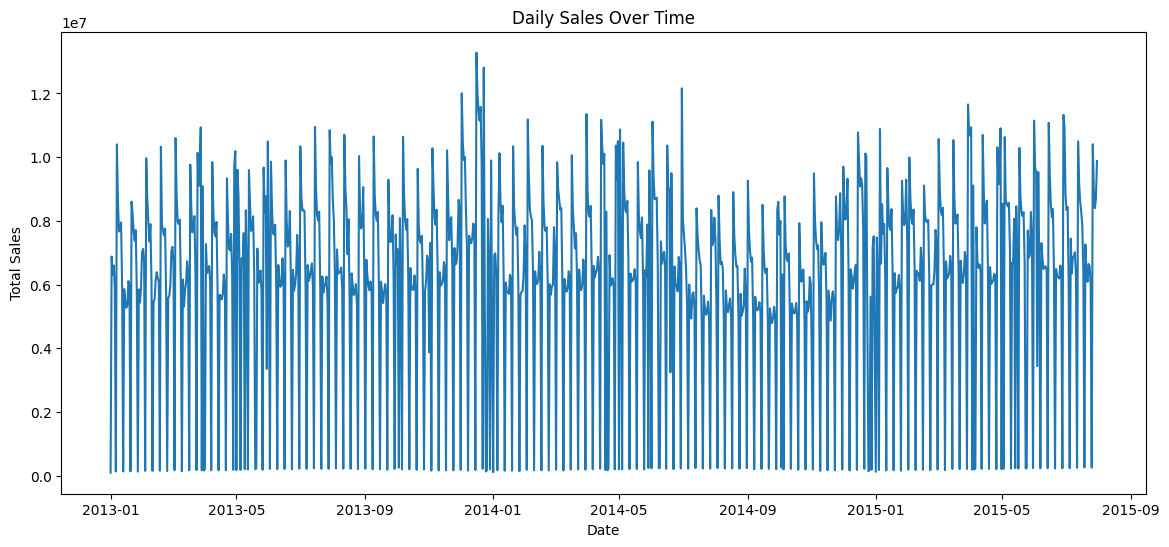

Displayed daily sales time series plot


In [135]:

logger.info("Displaying daily sales time series plot...")
plt.figure(figsize=(14,6))
plt.plot(daily_sales)
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()
print_and_log("Displayed daily sales time series plot")

_____________________________________________

#### **STEP 4 — CHECK STATIONARITY (ADF TEST)**
Time-series models (like ARIMA) require stationary data — meaning the statistical properties (mean, variance) remain constant over time.
A non-stationary series with trends or seasonal patterns violates ARIMA assumptions and produces unreliable forecasts.

**Augmented Dickey-Fuller (ADF) Test:** This hypothesis test determines if the series is stationary.
- **Null Hypothesis (H₀):** The series has a unit root (non-stationary)
- **Decision Rule:** If p-value ≤ 0.05, reject H₀ → data is STATIONARY; if p-value > 0.05, fail to reject H₀ → data is NON-STATIONARY

In [136]:
logger.info("Performing Augmented Dickey-Fuller test for stationarity...")
adf_test = adfuller(daily_sales)

print_and_log(f"ADF Statistic: {adf_test[0]:.6f}")
print_and_log(f"p-value: {adf_test[1]:.6f}")
print_and_log(f"Number of Lags Used: {adf_test[2]}")
print_and_log(f"Number of Observations: {adf_test[3]}")

# Interpretation
if adf_test[1] <= 0.05:
    print_and_log("Result: Data is STATIONARY (p-value ≤ 0.05)")
    logger.info("Data is stationary - can proceed with forecasting models")
else:
    print_and_log("Result: Data is NON-STATIONARY (p-value > 0.05) - Differencing required")
    logger.warning("Data is non-stationary - differencing transformation needed")

ADF Statistic: -4.667800
p-value: 0.000097
Number of Lags Used: 20
Number of Observations: 921
Result: Data is STATIONARY (p-value ≤ 0.05)


_____________________________________________

#### **STEP 5 — DIFFERENCING (MAKE STATIONARY)**

If the ADF test indicates non-stationarity, we apply differencing — computing the differences between consecutive observations.Differencing is the 'd' parameter in ARIMA(p,d,q) and stabilizes the mean of the series for forecasting.
First-order differencing (d=1) removes linear trends, while higher-order differencing removes more complex patterns.

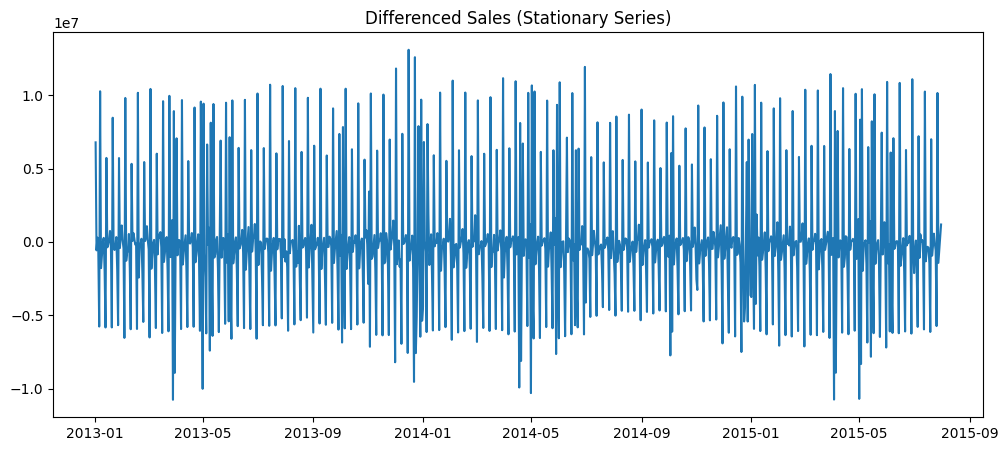

Displayed differenced sales time series plot


In [137]:
logger.info("Applying first-order differencing to achieve stationarity...")
sales_diff = daily_sales.diff().dropna()
plt.figure(figsize=(12,5))
plt.plot(sales_diff)
plt.title("Differenced Sales (Stationary Series)")
plt.show()
print_and_log("Displayed differenced sales time series plot")

_____________________________________________

#### **STEP 6 — ACF & PACF PLOTS**
Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots visualize correlations between past and present values.

These plots help identify the AR (p) and MA (q) components of ARIMA(p,d,q) by showing which lags have significant correlations.- **PACF:** Shows direct correlation after removing intermediate lags; guides the AR order (p)
- **ACF:** Shows correlation at each lag; guides the MA order (q)

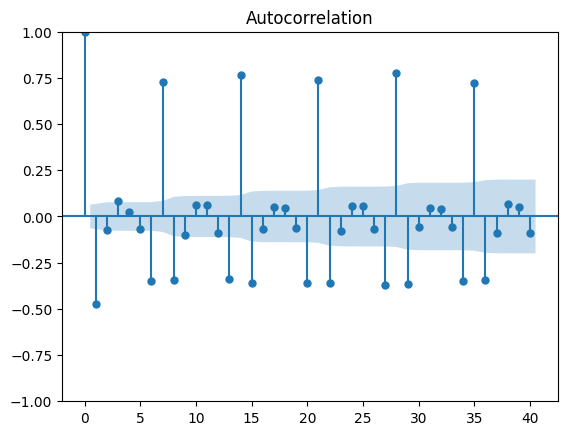

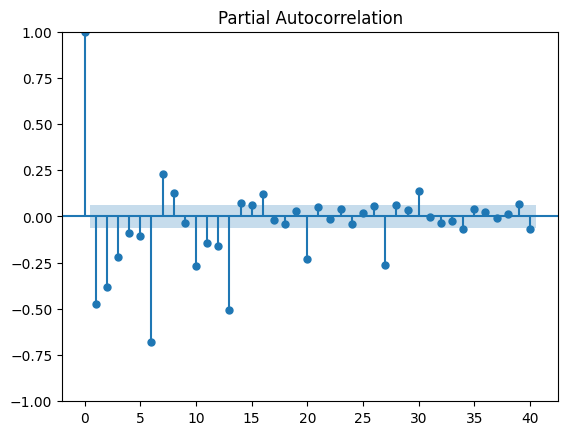

Displayed ACF and PACF plots for differenced sales data


In [138]:
logger.info("Generating ACF and PACF plots for differenced sales data...")
plot_acf(sales_diff, lags=40)
plot_pacf(sales_diff, lags=40)
plt.show()
print_and_log("Displayed ACF and PACF plots for differenced sales data")

_____________________________________________

#### **STEP 7 — BUILD ARIMA MODEL**
ARIMA (AutoRegressive Integrated Moving Average) is a statistical model for time series forecasting.
It combines three key components to capture different patterns in the data:

**ARIMA Parameters (p,d,q):**
- **p (Autoregressive):** Number of past values used to predict the current value (from PACF plot)
- **d (Integrated/Differencing):** Order of differencing to make data stationary (from ADF test result)

- **q (Moving Average):** Number of past forecast errors used in the prediction (from ACF plot)We fit the model on historical sales data to learn patterns and estimate coefficients.


In [139]:
logger.info("Fitting ARIMA model with order (5,1,2)...")
model = ARIMA(daily_sales, order=(5,1,2))
model_fit = model.fit()

logger.info("ARIMA model fitted")
print(model_fit.summary())
print_and_log("ARIMA model fitted and summary displayed!")

c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationar

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  942
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -15388.505
Date:                Mon, 16 Feb 2026   AIC                          30793.010
Time:                        03:32:21   BIC                          30831.786
Sample:                    01-01-2013   HQIC                         30807.791
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8261      0.044    -18.934      0.000      -0.912      -0.741
ar.L2         -0.1247      0.033     -3.726      0.000      -0.190      -0.059
ar.L3         -0.0703      0.036     -1.940      0.0

_____________________________________________

#### **STEP 8 — FORECAST NEXT 6 WEEKS**
Using the fitted ARIMA model, we generate point forecasts for the next 42 days (6 weeks × 7 days).

The model uses learned temporal patterns and coefficients to predict future sales values based on historical trends and seasonality.This forecast enables inventory planning, staffing decisions, and revenue projections for the upcoming 6-week period.

In [140]:
logger.info("Generating 42-day forecast using the fitted ARIMA model...")
forecast = model_fit.forecast(steps=42)
print_and_log("Generated 42-day forecast using the fitted ARIMA model")
forecast.head()

Generated 42-day forecast using the fitted ARIMA model


2015-08-01    7.273610e+06
2015-08-02    5.140067e+06
2015-08-03    7.083692e+06
2015-08-04    5.853319e+06
2015-08-05    7.057983e+06
Freq: D, Name: predicted_mean, dtype: float64

_____________________________________________

#### **STEP 9 — CREATE FORECAST DATES**

We generate future dates starting from the last date in the historical data for the next 42 days.This formatted forecast can be directly used for business decisions, presentations, and downstream analysis.
Combining forecasted sales values with corresponding dates creates a structured DataFrame for easy interpretation and analysis.

In [141]:
logger.info("Creating forecast DataFrame with future dates and forecasted sales...")
last_date = daily_sales.index[-1]
future_dates = pd.date_range(start=last_date, periods=43, freq="D")[1:]

forecast_df = pd.DataFrame({
    "date": future_dates,
    "forecast_sales": forecast
})
print_and_log("Created forecast DataFrame with future dates and forecasted sales")

Created forecast DataFrame with future dates and forecasted sales


_____________________________________________

#### **STEP 10 — PLOT FORECAST**

Visualize the forecasted sales alongside recent historical data to assess forecast reasonableness and identify trends.Plotting both historical and forecasted data enables quick validation that forecasts are realistic and consistent with past behavior.
This visualization helps stakeholders understand the predicted sales trajectory and makes it easy to identify anomalies or unexpected patterns.

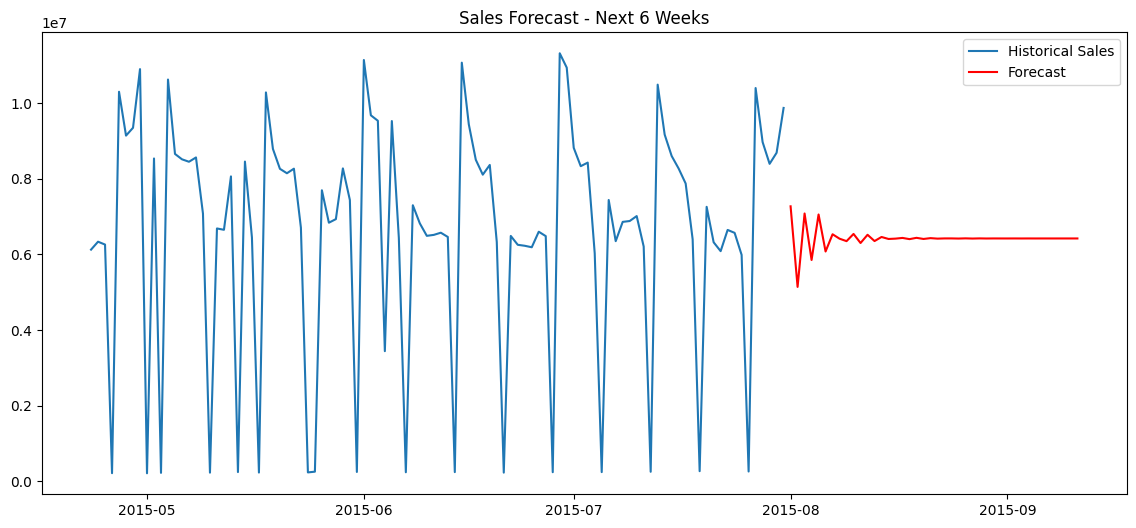

Displayed sales forecast plot for the next 6 weeks


In [142]:
logger.info("Displaying sales forecast plot for the next 6 weeks...")
plt.figure(figsize=(14,6))
plt.plot(daily_sales[-100:], label="Historical Sales")
plt.plot(forecast_df["date"], forecast_df["forecast_sales"], label="Forecast", color="red")
plt.legend()
plt.title("Sales Forecast - Next 6 Weeks")
plt.show()
print_and_log("Displayed sales forecast plot for the next 6 weeks")

_____________________________________________

#### **STEP 11 — SAVE FORECAST**

Export the 6-week sales forecast to a CSV file for use by business teams, inventory management, and planning departments.Saving forecasts enables version control and allows comparison with actual sales to measure model performance over time.
This persistent storage ensures the forecast is accessible for reference, integration with BI tools, and historical tracking of forecast accuracy.

In [143]:
logger.info("Saving forecast to sales_forecast_6weeks.csv...")
forecast_df.to_csv("sales_forecast_6weeks.csv", index=False)
print_and_log("Forecast saved to sales_forecast_6weeks.csv")
print_and_log("===== TIME SERIES FORECASTING COMPLETED =====")

Forecast saved to sales_forecast_6weeks.csv
===== TIME SERIES FORECASTING COMPLETED =====
